In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import os
sys.path.append(os.path.dirname(os.getcwd()))
from bart_playground import *

import bartz

## 4 Special Moves

In [2]:
proposal_probs = {"grow" : 0.5, "prune" : 0.5}
#special_probs = {"break": 0.5, "combine": 0.5}
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

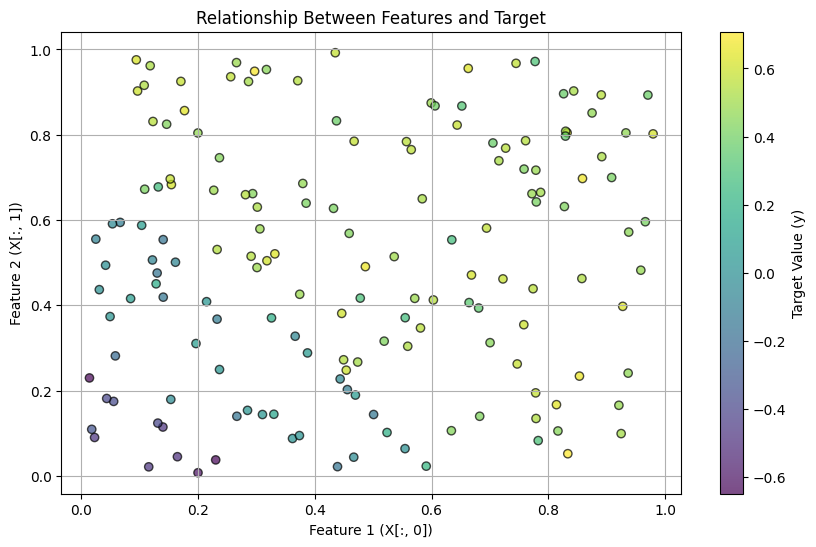

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.colorbar(scatter, label='Target Value (y)')
plt.title('Relationship Between Features and Target')
plt.xlabel('Feature 1 (X[:, 0])')
plt.ylabel('Feature 2 (X[:, 1])')
plt.grid(True)
plt.show()

### Bernoulli prior with n_trees = 50 or 51

In [4]:
bart = ChangeNumTreeBART(ndpost=2000, nskip=2000, n_trees=50, 
                         proposal_probs=proposal_probs, special_probs = special_probs, 
                         theta_0 = 100, theta_df = np.inf, 
                         tree_num_prior_type="bernoulli", special_move_interval=1)
bart.fit(X_train, y_train)

Iterations: 100%|██████████| 4000/4000 [02:22<00:00, 28.08it/s]


In [5]:
bart.trace[-1].n_trees

51

In [6]:
bart.trace[-1].global_params

{'eps_sigma2': array([0.00470823]), 'ntree_theta': 100}

In [7]:
# Extract the n_trees value for each instance
n_trees_list = [instance.n_trees for instance in bart.trace]
np.mean(n_trees_list)

50.3575

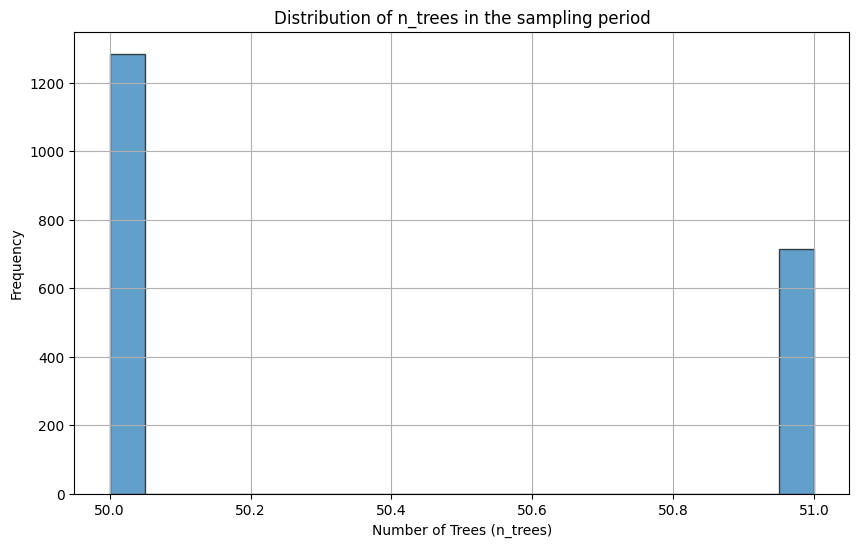

In [8]:
# Create a histogram with bins for each integer value
plt.figure(figsize=(10, 6))
plt.hist(n_trees_list, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of n_trees in the sampling period')
plt.xlabel('Number of Trees (n_trees)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

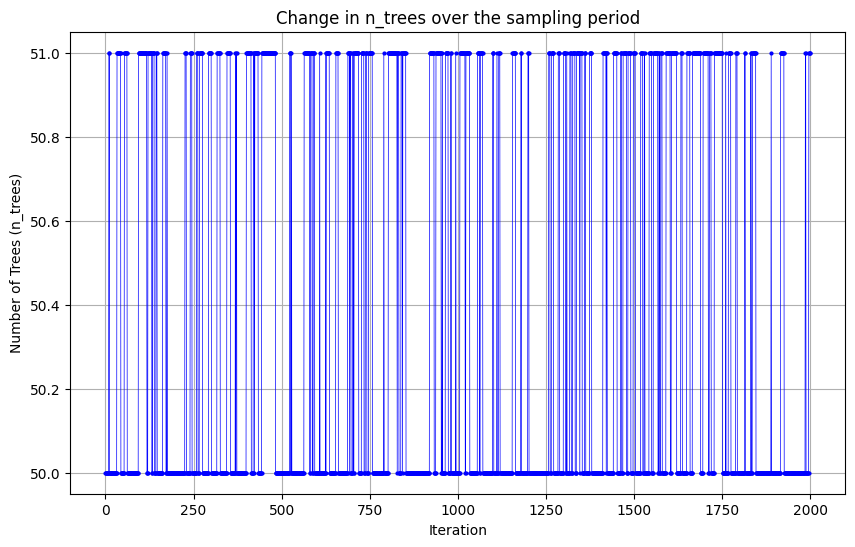

In [9]:
# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(len(n_trees_list)), 
    n_trees_list, 
    marker='o', 
    markersize=2,  # Adjust marker size
    linestyle='-', 
    linewidth=0.5,  # Adjust line width
    color='b'
)
plt.title('Change in n_trees over the sampling period')
plt.xlabel('Iteration')
plt.ylabel('Number of Trees (n_trees)')
plt.grid(True)
plt.show()

In [10]:
ntree = bart.trace[-1].n_trees
rf = RandomForestRegressor(n_estimators=ntree)
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=ntree, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

INFO:2025-04-17 17:01:07,444:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-04-17 17:01:07,457:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 100/300 P_grow=0.55 P_prune=0.45 A_grow=0.14 A_prune=0.30 (burnin)
Iteration 200/300 P_grow=0.47 P_prune=0.53 A_grow=0.29 A_prune=0.41
Iteration 300/300 P_grow=0.61 P_prune=0.39 A_grow=0.35 A_prune=0.30


In [11]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.13398331392260424,
 'rf': 0.01943580394414674,
 'lr': 0.048045521328019404,
 'btz': 0.02333483026012838}

In [12]:
print(f'Birth move count: {len(bart.sampler.birth_mh_ratios)}; mh median: {np.median(bart.sampler.birth_mh_ratios)}')

Birth move count: 647; mh median: 0.011755436223382373


In [13]:
print(f'Birth move likelihood median: {np.median(bart.sampler.birth_likelihood_ratios)}')

Birth move likelihood median: 0.2197452537750363


In [14]:
print(f'Death move count: {len(bart.sampler.death_mh_ratios)}; mh median: {np.median(bart.sampler.death_mh_ratios)}')

Death move count: 16; mh median: 31.623501168325493


In [15]:
print(f'Break move count: {len(bart.sampler.break_mh_ratios)}; mh median: {np.median(bart.sampler.break_mh_ratios)}')

Break move count: 270; mh median: 0.7513920008855582


In [16]:
print(f'Combine move count: {len(bart.sampler.combine_mh_ratios)}; mh median: {np.median(bart.sampler.combine_mh_ratios)}')

Combine move count: 294; mh median: 0.7564062256145228


In [17]:
bart.trace[-1].trees

[Tree(vars=[ 1 -1 -1 -2], thresholds=[0.1061896       nan       nan       nan], leaf_vals=[        nan -0.01906316  0.03538933         nan], n_vals=[120  14 106  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.6617021       nan       nan       nan], leaf_vals=[        nan -0.01921448  0.01179367         nan], n_vals=[120  77  43  -2]),
 Tree(vars=[ 0  0 -1 -1 -1 -2 -2 -2], thresholds=[0.92718166 0.61580157        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan -0.04361713  0.00571848  0.00236683         nan
          nan         nan], n_vals=[120 112   8  78  34  -2  -2  -2]),
 Tree(vars=[ 1 -1 -1 -2], thresholds=[0.67619566        nan        nan        nan], leaf_vals=[        nan -0.01887124  0.02861542         nan], n_vals=[120  80  40  -2]),
 Tree(vars=[ 1  0 -1 -1 -1 -2 -2 -2], thresholds=[0.41151293 0.28271184        nan        nan        nan        nan
         nan        nan], leaf_vals=[        nan         nan  0.05000625 -0.0212

In [29]:
X_sample = X_test[1].reshape(1, -1)
X_sample

array([[0.13105775, 0.1237538 ]])

In [30]:
y_test[1]

-0.39107825032892074

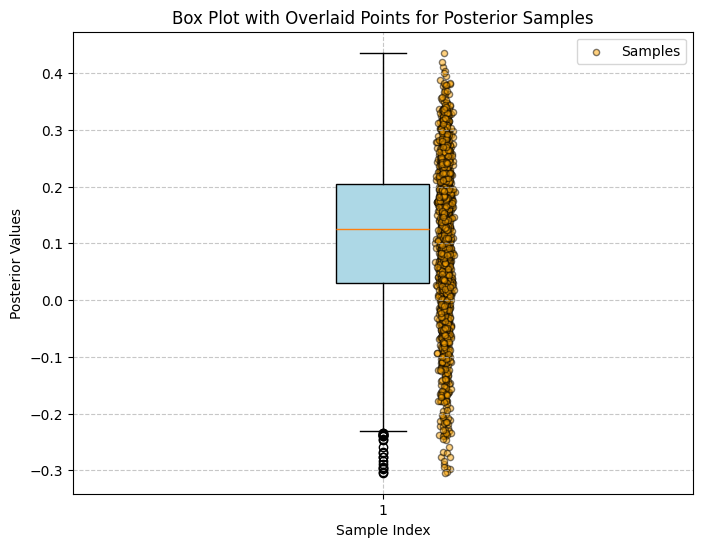

In [31]:
import matplotlib.pyplot as plt
import numpy as np

posterior_values = bart.posterior_f(X_sample)

plt.figure(figsize=(8, 6))
plt.boxplot(posterior_values[0], vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(posterior_values.shape[1]):
    y = posterior_values[:, i]
    x = np.random.normal(1.1, 0.005, size=len(y))
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Posterior Samples')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [32]:
eval_single = [float(bart.trace[-1].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]
eval_single

C:\Windows\Temp\ipykernel_4408\3961633740.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  eval_single = [float(bart.trace[-1].trees[i].evaluate(X_sample)) for i in range(len(bart.trace[0].trees))]


[0.03538932766900372,
 -0.019214478697513613,
 0.0057184771832397,
 -0.018871238007533247,
 -0.02128893801866271,
 0.017797524883054656,
 0.014680341868612353,
 0.07312965039426124,
 -0.07084809173069047,
 0.002518684361920672,
 -0.02948101827684286,
 0.02358010709025114,
 0.020906258385583843,
 -0.01096427278468039,
 0.030674465561029134,
 0.03558205290896345,
 -0.021203338384792388,
 -0.013768842676620034,
 0.005195528364128657,
 0.011256516076774057,
 0.026194886135627166,
 0.0031801172187521324,
 -0.005849707307356536,
 0.054037477109243184,
 0.0190157284146813,
 -0.005566363030241278,
 -0.02744006186854938,
 0.01345432971352258,
 0.04244480663598987,
 0.05263622743992313,
 -0.02502133913861691,
 -0.013614353270476946,
 -0.03145157585810149,
 -0.0035722999923506384,
 0.049023068370461276,
 -0.041087456999628034,
 0.013688023237275922,
 -0.014492793671518142,
 -0.10334157072279611,
 0.02790494506172682,
 0.048839453105374506,
 -0.04872546908587248,
 0.012139952566878933,
 0.02382236

In [33]:
len(eval_single)

50

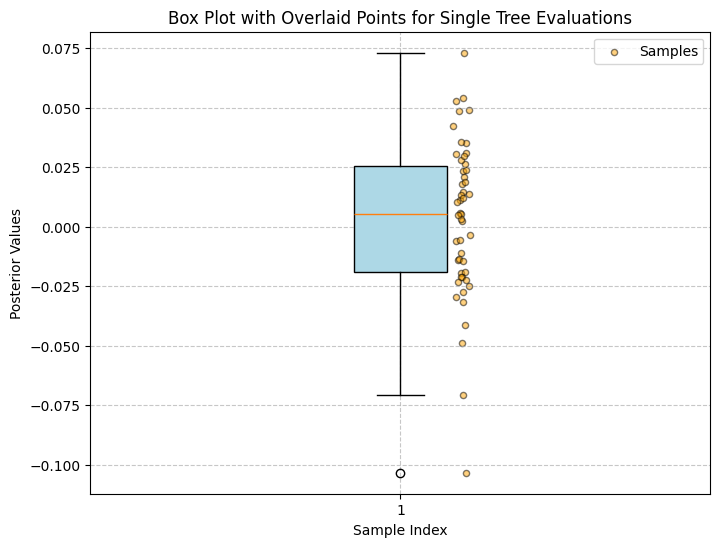

In [34]:
plt.figure(figsize=(8, 6))
plt.boxplot(eval_single, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
for i in range(len(eval_single)):
    y = eval_single[i]
    x = np.random.normal(1.1, 0.005, size=1)
    plt.scatter(x, y, alpha=0.5, color='orange', edgecolor='k', s=20, label='Samples' if i == 0 else None)

plt.title('Box Plot with Overlaid Points for Single Tree Evaluations')
plt.ylabel('Posterior Values')
plt.xlabel('Sample Index')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [35]:
np.sum(eval_single)

0.16741850840758532

In [36]:
eval = [bart.trace[i].evaluate(X_sample) for i in range(len(bart.trace))]
eval

[array([-0.14915699]),
 array([-0.15139148]),
 array([-0.17681916]),
 array([-0.14162708]),
 array([-0.14223718]),
 array([-0.15344497]),
 array([-0.11316846]),
 array([-0.19612636]),
 array([-0.03400153]),
 array([-0.06800036]),
 array([-0.00091086]),
 array([-0.06281126]),
 array([-0.13859448]),
 array([-0.10295]),
 array([-0.1296639]),
 array([-0.12703125]),
 array([-0.07174023]),
 array([-0.12092506]),
 array([-0.10110521]),
 array([-0.15259959]),
 array([-0.10933933]),
 array([-0.1037381]),
 array([-0.1134513]),
 array([-0.08711369]),
 array([-0.05830824]),
 array([-0.01732652]),
 array([-0.06222119]),
 array([-0.04710373]),
 array([-0.06187004]),
 array([-0.00988573]),
 array([-0.02369679]),
 array([-0.06549586]),
 array([-0.06280122]),
 array([-0.09366007]),
 array([-0.05146811]),
 array([-0.06479298]),
 array([-0.0696944]),
 array([-0.07804324]),
 array([-0.08454447]),
 array([-0.05377349]),
 array([-0.09540923]),
 array([-0.06667097]),
 array([-0.07292007]),
 array([-0.0637826

In [40]:
np.mean(eval)

0.06120263080401222

In [37]:
y_test

array([ 0.57494339, -0.39107825,  0.03833771, -0.10585361,  0.58205285,
       -0.46879905, -0.12964723,  0.48524713,  0.30069396,  0.48688625,
        0.49330468,  0.4528224 ,  0.5750869 ,  0.55541165,  0.43010696,
        0.6155312 ,  0.44660998,  0.51601906,  0.48824578,  0.18206462,
        0.37483528, -0.15720403,  0.57823503,  0.43025762,  0.56087615,
        0.49741372, -0.02658388,  0.4874991 ,  0.04278904, -0.06782644,
       -0.03427862,  0.54396366,  0.52023062, -0.14805365,  0.61774119,
        0.54746971,  0.58137637, -0.46316434,  0.29964777,  0.55300647])

In [38]:
btpred

array([ 0.37758687, -0.3301336 , -0.03742742,  0.16604449,  0.580386  ,
       -0.3324432 ,  0.21600884,  0.5976371 ,  0.55488664,  0.41384706,
        0.31020385,  0.6153373 ,  0.5292348 ,  0.3850233 ,  0.40470448,
        0.45199436,  0.564123  ,  0.5587547 ,  0.46608132,  0.2953705 ,
        0.5488207 ,  0.14131936,  0.4811879 ,  0.50464475,  0.4866819 ,
        0.5218896 , -0.32082236,  0.38894352,  0.03740606,  0.17077944,
        0.01847693,  0.50904226,  0.43088827,  0.05603127,  0.5378228 ,
        0.40066543,  0.40542817, -0.42070073,  0.4814171 ,  0.50928557],
      dtype=float32)

In [39]:
y_pred = bart.predict(X_test)
y_pred

array([ 1.94297037e-01,  1.12725419e-01,  1.52596136e-01,  2.35416270e-01,
        3.25928417e-01,  1.07049731e-01,  3.02435813e-01,  3.37189940e-02,
        9.06080817e-02,  2.21251981e-01,  2.44659815e-02,  2.43318780e-04,
        1.05905232e-01,  2.05205103e-01,  2.90283474e-01,  2.11070218e-01,
        3.28272256e-01,  3.93762867e-02,  6.21544619e-02,  7.90291181e-02,
        5.37523800e-02,  2.05297628e-02,  2.86527797e-01,  1.68461619e-01,
        1.30578669e-01,  2.22719657e-01,  1.10138560e-01,  7.59015033e-02,
        2.05829427e-01,  1.24099201e-02, -3.52514085e-02,  5.77972843e-02,
        1.48787222e-01,  1.17938247e-02, -4.17672713e-03,  2.11184472e-01,
        7.94070581e-02,  1.11007748e-01,  3.27691397e-01,  1.21925336e-02])

1 tree
50/51 trees